# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
       
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"
        
        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11742
EM converged at iteration 66, llf=-11500, convergence criterion=9.7216e-07 < tolerance=1e-06
EM start iterations, llf=-11755
EM converged at iteration 66, llf=-11512, convergence criterion=9.7126e-07 < tolerance=1e-06
EM start iterations, llf=-11808
EM converged at iteration 65, llf=-11562, convergence criterion=9.8227e-07 < tolerance=1e-06
EM start iterations, llf=-11815
EM converged at iteration 65, llf=-11569, convergence criterion=9.8219e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 63, llf=-11632, convergence criterion=9.8485e-07 < tolerance=1e-06
EM start iterations, llf=-11892
EM converged at iteration 63, llf=-11639, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-11944
EM converged at iteration 63, llf=-11692, convergence criterion=9.7517e-07 < tolerance=1e-06
EM start iterations, llf=-11944
EM converged at iteration 63, llf=-11692, convergence criterion=9.7517e-07 < tolerance=1e-06


EM start iterations, llf=-13445
EM converged at iteration 53, llf=-13251, convergence criterion=9.9712e-07 < tolerance=1e-06
EM start iterations, llf=-13505
EM converged at iteration 52, llf=-13321, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-13511
EM converged at iteration 52, llf=-13324, convergence criterion=9.8905e-07 < tolerance=1e-06
EM start iterations, llf=-13561
EM converged at iteration 52, llf=-13369, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-13561
EM converged at iteration 52, llf=-13369, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-13572
EM converged at iteration 52, llf=-13382, convergence criterion=9.8541e-07 < tolerance=1e-06
EM start iterations, llf=-13623
EM converged at iteration 52, llf=-13435, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-13628
EM converged at iteration 52, llf=-13439, convergence criterion=9.8199e-07 < tolerance=1e-06


EM start iterations, llf=-15171
EM converged at iteration 52, llf=-14965, convergence criterion=9.6243e-07 < tolerance=1e-06
EM start iterations, llf=-15171
EM converged at iteration 52, llf=-14965, convergence criterion=9.6243e-07 < tolerance=1e-06
EM start iterations, llf=-15180
EM converged at iteration 51, llf=-14974, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-15234
EM converged at iteration 51, llf=-15028, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-15245
EM converged at iteration 51, llf=-15039, convergence criterion=9.9535e-07 < tolerance=1e-06
EM start iterations, llf=-15294
EM converged at iteration 52, llf=-15087, convergence criterion=9.6292e-07 < tolerance=1e-06
EM start iterations, llf=-15301
EM converged at iteration 51, llf=-15094, convergence criterion=9.9931e-07 < tolerance=1e-06
EM start iterations, llf=-15348
EM converged at iteration 51, llf=-15140, convergence criterion=9.9312e-07 < tolerance=1e-06


EM start iterations, llf=-16865
EM converged at iteration 60, llf=-16626, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-16870
EM converged at iteration 60, llf=-16631, convergence criterion=9.8551e-07 < tolerance=1e-06
EM start iterations, llf=-16925
EM converged at iteration 60, llf=-16686, convergence criterion=9.8937e-07 < tolerance=1e-06
EM start iterations, llf=-16932
EM converged at iteration 60, llf=-16692, convergence criterion=9.8954e-07 < tolerance=1e-06
EM start iterations, llf=-16988
EM converged at iteration 60, llf=-16749, convergence criterion=9.8626e-07 < tolerance=1e-06
EM start iterations, llf=-16988
EM converged at iteration 60, llf=-16749, convergence criterion=9.8626e-07 < tolerance=1e-06
EM start iterations, llf=-16997
EM converged at iteration 60, llf=-16759, convergence criterion=9.8458e-07 < tolerance=1e-06
EM start iterations, llf=-17049
EM converged at iteration 60, llf=-16810, convergence criterion=9.8169e-07 < tolerance=1e-06


EM start iterations, llf=-18390
EM converged at iteration 60, llf=-18138, convergence criterion=9.8586e-07 < tolerance=1e-06
EM start iterations, llf=-18448
EM converged at iteration 60, llf=-18195, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-18448
EM converged at iteration 60, llf=-18195, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-18454
EM converged at iteration 60, llf=-18200, convergence criterion=9.7831e-07 < tolerance=1e-06
EM start iterations, llf=-18505
EM converged at iteration 60, llf=-18250, convergence criterion=9.7968e-07 < tolerance=1e-06
EM start iterations, llf=-18512
EM converged at iteration 60, llf=-18258, convergence criterion=9.791e-07 < tolerance=1e-06
EM start iterations, llf=-18569
EM converged at iteration 60, llf=-18313, convergence criterion=9.9739e-07 < tolerance=1e-06
EM start iterations, llf=-18577
EM converged at iteration 60, llf=-18321, convergence criterion=9.9725e-07 < tolerance=1e-06
E

EM start iterations, llf=-12283
EM converged at iteration 62, llf=-12016, convergence criterion=9.9076e-07 < tolerance=1e-06
EM start iterations, llf=-12265
EM converged at iteration 62, llf=-11996, convergence criterion=9.9075e-07 < tolerance=1e-06
EM start iterations, llf=-12323
EM converged at iteration 63, llf=-12066, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-12342
EM converged at iteration 63, llf=-12091, convergence criterion=9.9557e-07 < tolerance=1e-06
EM start iterations, llf=-12409
EM converged at iteration 64, llf=-12179, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-12408
EM converged at iteration 64, llf=-12176, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-12425
EM converged at iteration 63, llf=-12201, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-12425
EM converged at iteration 63, llf=-12201, convergence criterion=9.7154e-07 < tolerance=1e-06


EM start iterations, llf=-13989
EM converged at iteration 67, llf=-13785, convergence criterion=9.983e-07 < tolerance=1e-06
EM start iterations, llf=-14027
EM converged at iteration 66, llf=-13815, convergence criterion=9.8897e-07 < tolerance=1e-06
EM start iterations, llf=-14032
EM converged at iteration 67, llf=-13827, convergence criterion=9.915e-07 < tolerance=1e-06
EM start iterations, llf=-14082
EM converged at iteration 68, llf=-13884, convergence criterion=9.9447e-07 < tolerance=1e-06
EM start iterations, llf=-14082
EM converged at iteration 68, llf=-13884, convergence criterion=9.9447e-07 < tolerance=1e-06
EM start iterations, llf=-14093
EM converged at iteration 68, llf=-13895, convergence criterion=9.9688e-07 < tolerance=1e-06
EM start iterations, llf=-14146
EM converged at iteration 66, llf=-13947, convergence criterion=9.8873e-07 < tolerance=1e-06
EM start iterations, llf=-14153
EM converged at iteration 65, llf=-13953, convergence criterion=9.9887e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15723
EM converged at iteration 58, llf=-15503, convergence criterion=9.8472e-07 < tolerance=1e-06
EM start iterations, llf=-15723
EM converged at iteration 58, llf=-15503, convergence criterion=9.8472e-07 < tolerance=1e-06
EM start iterations, llf=-15732
EM converged at iteration 58, llf=-15511, convergence criterion=9.7267e-07 < tolerance=1e-06
EM start iterations, llf=-15784
EM converged at iteration 58, llf=-15561, convergence criterion=9.7058e-07 < tolerance=1e-06
EM start iterations, llf=-15786
EM converged at iteration 58, llf=-15563, convergence criterion=9.7273e-07 < tolerance=1e-06
EM start iterations, llf=-15842
EM converged at iteration 58, llf=-15618, convergence criterion=9.9819e-07 < tolerance=1e-06
EM start iterations, llf=-15847
EM converged at iteration 58, llf=-15622, convergence criterion=9.9627e-07 < tolerance=1e-06
EM start iterations, llf=-15891
EM converged at iteration 59, llf=-15666, convergence criterion=9.6907e-07 < tolerance=1e-06


EM start iterations, llf=-17426
EM converged at iteration 68, llf=-17190, convergence criterion=9.8606e-07 < tolerance=1e-06
EM start iterations, llf=-17432
EM converged at iteration 68, llf=-17196, convergence criterion=9.8524e-07 < tolerance=1e-06
EM start iterations, llf=-17485
EM converged at iteration 69, llf=-17248, convergence criterion=9.7722e-07 < tolerance=1e-06
EM start iterations, llf=-17493
EM converged at iteration 68, llf=-17255, convergence criterion=9.9821e-07 < tolerance=1e-06
EM start iterations, llf=-17540
EM converged at iteration 68, llf=-17301, convergence criterion=9.87e-07 < tolerance=1e-06
EM start iterations, llf=-17540
EM converged at iteration 68, llf=-17301, convergence criterion=9.87e-07 < tolerance=1e-06
EM start iterations, llf=-17559
EM converged at iteration 68, llf=-17321, convergence criterion=9.8678e-07 < tolerance=1e-06
EM start iterations, llf=-17610
EM converged at iteration 67, llf=-17372, convergence criterion=9.9879e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-18936
EM converged at iteration 66, llf=-18669, convergence criterion=9.9153e-07 < tolerance=1e-06
EM start iterations, llf=-18985
EM converged at iteration 66, llf=-18719, convergence criterion=9.8505e-07 < tolerance=1e-06
EM start iterations, llf=-18985
EM converged at iteration 66, llf=-18719, convergence criterion=9.8505e-07 < tolerance=1e-06
EM start iterations, llf=-18992
EM converged at iteration 66, llf=-18728, convergence criterion=9.8594e-07 < tolerance=1e-06
EM start iterations, llf=-19051
EM converged at iteration 66, llf=-18786, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-19058
EM converged at iteration 66, llf=-18794, convergence criterion=9.9595e-07 < tolerance=1e-06
EM start iterations, llf=-19111
EM converged at iteration 66, llf=-18845, convergence criterion=9.8662e-07 < tolerance=1e-06
EM start iterations, llf=-19120
EM converged at iteration 66, llf=-18854, convergence criterion=9.853e-07 < tolerance=1e-06
E

EM start iterations, llf=-12764
EM converged at iteration 61, llf=-12551, convergence criterion=9.8738e-07 < tolerance=1e-06
EM start iterations, llf=-12770
EM converged at iteration 61, llf=-12557, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-12826
EM converged at iteration 61, llf=-12611, convergence criterion=9.7471e-07 < tolerance=1e-06
EM start iterations, llf=-12833
EM converged at iteration 61, llf=-12618, convergence criterion=9.7558e-07 < tolerance=1e-06
EM start iterations, llf=-12876
EM converged at iteration 58, llf=-12656, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-12887
EM converged at iteration 58, llf=-12665, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 58, llf=-12731, convergence criterion=9.7201e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 58, llf=-12731, convergence criterion=9.7201e-07 < tolerance=1e-06


EM start iterations, llf=-14498
EM converged at iteration 61, llf=-14300, convergence criterion=9.6663e-07 < tolerance=1e-06
EM start iterations, llf=-14557
EM converged at iteration 62, llf=-14363, convergence criterion=9.6976e-07 < tolerance=1e-06
EM start iterations, llf=-14566
EM converged at iteration 61, llf=-14368, convergence criterion=9.9185e-07 < tolerance=1e-06
EM start iterations, llf=-14620
EM converged at iteration 61, llf=-14424, convergence criterion=9.9694e-07 < tolerance=1e-06
EM start iterations, llf=-14620
EM converged at iteration 61, llf=-14424, convergence criterion=9.9694e-07 < tolerance=1e-06
EM start iterations, llf=-14628
EM converged at iteration 61, llf=-14430, convergence criterion=9.8813e-07 < tolerance=1e-06
EM start iterations, llf=-14683
EM converged at iteration 61, llf=-14484, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-14691
EM converged at iteration 61, llf=-14491, convergence criterion=9.7363e-07 < tolerance=1e-06


EM start iterations, llf=-16261
EM converged at iteration 58, llf=-16040, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-16261
EM converged at iteration 58, llf=-16040, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-16270
EM converged at iteration 58, llf=-16048, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-16323
EM converged at iteration 58, llf=-16100, convergence criterion=9.7052e-07 < tolerance=1e-06
EM start iterations, llf=-16332
EM converged at iteration 58, llf=-16109, convergence criterion=9.6883e-07 < tolerance=1e-06
EM start iterations, llf=-16380
EM converged at iteration 57, llf=-16157, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-16388
EM converged at iteration 57, llf=-16164, convergence criterion=9.9648e-07 < tolerance=1e-06
EM start iterations, llf=-16437
EM converged at iteration 57, llf=-16213, convergence criterion=9.9303e-07 < tolerance=1e-06


EM start iterations, llf=-17955
EM converged at iteration 64, llf=-17714, convergence criterion=9.9312e-07 < tolerance=1e-06
EM start iterations, llf=-17961
EM converged at iteration 64, llf=-17722, convergence criterion=9.939e-07 < tolerance=1e-06
EM start iterations, llf=-18014
EM converged at iteration 64, llf=-17773, convergence criterion=9.932e-07 < tolerance=1e-06
EM start iterations, llf=-18021
EM converged at iteration 64, llf=-17780, convergence criterion=9.927e-07 < tolerance=1e-06
EM start iterations, llf=-18076
EM converged at iteration 64, llf=-17834, convergence criterion=9.9115e-07 < tolerance=1e-06
EM start iterations, llf=-18076
EM converged at iteration 64, llf=-17834, convergence criterion=9.9115e-07 < tolerance=1e-06
EM start iterations, llf=-18080
EM converged at iteration 64, llf=-17837, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-18131
EM converged at iteration 64, llf=-17887, convergence criterion=9.8525e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-19194
EM converged at iteration 65, llf=-18926, convergence criterion=9.985e-07 < tolerance=1e-06
EM start iterations, llf=-19254
EM converged at iteration 65, llf=-18985, convergence criterion=9.9573e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:09:47.572441.
EM start iterations, llf=-11267
EM converged at iteration 62, llf=-11124, convergence criterion=9.7447e-07 < tolerance=1e-06
EM start iterations, llf=-11280
EM converged at iteration 62, llf=-11137, convergence criterion=9.7456e-07 < tolerance=1e-06
EM start iterations, llf=-11332
EM converged at iteration 61, llf=-11189, convergence criterion=9.7722e-07 < tolerance=1e-06
EM start iterations, llf=-11340
EM converged at iteration 61, llf=-11197, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-11401
EM converged at iteration 58, llf=-11258, convergence criterion=9.7539e-07 < tolerance=1e-06
EM start iterations, llf=-11412
EM converged at 

EM start iterations, llf=-12732
EM converged at iteration 54, llf=-12584, convergence criterion=9.7314e-07 < tolerance=1e-06
EM start iterations, llf=-12745
EM converged at iteration 54, llf=-12596, convergence criterion=9.7373e-07 < tolerance=1e-06
EM start iterations, llf=-12779
EM converged at iteration 54, llf=-12630, convergence criterion=9.7042e-07 < tolerance=1e-06
EM start iterations, llf=-12786
EM converged at iteration 54, llf=-12635, convergence criterion=9.7057e-07 < tolerance=1e-06
EM start iterations, llf=-12843
EM converged at iteration 53, llf=-12685, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-12847
EM converged at iteration 53, llf=-12692, convergence criterion=9.7939e-07 < tolerance=1e-06
EM start iterations, llf=-12886
EM converged at iteration 52, llf=-12732, convergence criterion=9.9358e-07 < tolerance=1e-06
EM start iterations, llf=-12886
EM converged at iteration 52, llf=-12732, convergence criterion=9.9358e-07 < tolerance=1e-06


EM start iterations, llf=-14331
EM converged at iteration 48, llf=-14171, convergence criterion=9.8702e-07 < tolerance=1e-06
EM start iterations, llf=-14390
EM converged at iteration 49, llf=-14230, convergence criterion=9.8213e-07 < tolerance=1e-06
EM start iterations, llf=-14398
EM converged at iteration 49, llf=-14237, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-14445
EM converged at iteration 49, llf=-14284, convergence criterion=9.7506e-07 < tolerance=1e-06
EM start iterations, llf=-14445
EM converged at iteration 49, llf=-14284, convergence criterion=9.7506e-07 < tolerance=1e-06
EM start iterations, llf=-14453
EM converged at iteration 49, llf=-14293, convergence criterion=9.7807e-07 < tolerance=1e-06
EM start iterations, llf=-14504
EM converged at iteration 49, llf=-14343, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-14511
EM converged at iteration 49, llf=-14351, convergence criterion=9.697e-07 < tolerance=1e-06
E

EM start iterations, llf=-16014
EM converged at iteration 59, llf=-15846, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-16014
EM converged at iteration 59, llf=-15846, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-16028
EM converged at iteration 59, llf=-15859, convergence criterion=9.852e-07 < tolerance=1e-06
EM start iterations, llf=-16083
EM converged at iteration 59, llf=-15916, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-16086
EM converged at iteration 59, llf=-15919, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-16140
EM converged at iteration 59, llf=-15973, convergence criterion=9.8777e-07 < tolerance=1e-06
EM start iterations, llf=-16147
EM converged at iteration 59, llf=-15979, convergence criterion=9.87e-07 < tolerance=1e-06
EM start iterations, llf=-16199
EM converged at iteration 59, llf=-16032, convergence criterion=9.8724e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17465
EM converged at iteration 60, llf=-17291, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-17479
EM converged at iteration 60, llf=-17305, convergence criterion=9.7982e-07 < tolerance=1e-06
EM start iterations, llf=-17537
EM converged at iteration 60, llf=-17361, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-17542
EM converged at iteration 60, llf=-17367, convergence criterion=9.8001e-07 < tolerance=1e-06
EM start iterations, llf=-17597
EM converged at iteration 60, llf=-17421, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-17597
EM converged at iteration 60, llf=-17421, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 60, llf=-17427, convergence criterion=9.7218e-07 < tolerance=1e-06
EM start iterations, llf=-17650
EM converged at iteration 60, llf=-17474, convergence criterion=9.7184e-07 < tolerance=1e-06


EM start iterations, llf=-11706
EM converged at iteration 70, llf=-11559, convergence criterion=9.8371e-07 < tolerance=1e-06
EM start iterations, llf=-11708
EM converged at iteration 69, llf=-11561, convergence criterion=9.8164e-07 < tolerance=1e-06
EM start iterations, llf=-11773
EM converged at iteration 66, llf=-11625, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-11773
EM converged at iteration 66, llf=-11625, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-11784
EM converged at iteration 67, llf=-11639, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-11855
EM converged at iteration 67, llf=-11714, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-11841
EM converged at iteration 67, llf=-11700, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-11863
EM converged at iteration 67, llf=-11714, convergence criterion=9.7562e-07 < tolerance=1e-06


EM start iterations, llf=-13235
EM converged at iteration 72, llf=-13074, convergence criterion=9.895e-07 < tolerance=1e-06
EM start iterations, llf=-13243
EM converged at iteration 71, llf=-13084, convergence criterion=9.9542e-07 < tolerance=1e-06
EM start iterations, llf=-13289
EM converged at iteration 72, llf=-13130, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-13298
EM converged at iteration 72, llf=-13138, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-13342
EM converged at iteration 72, llf=-13181, convergence criterion=9.9021e-07 < tolerance=1e-06
EM start iterations, llf=-13334
EM converged at iteration 72, llf=-13178, convergence criterion=9.8902e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 70, llf=-13222, convergence criterion=9.9766e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 70, llf=-13222, convergence criterion=9.9766e-07 < tolerance=1e-06
E

EM start iterations, llf=-14862
EM converged at iteration 56, llf=-14701, convergence criterion=9.7399e-07 < tolerance=1e-06
EM start iterations, llf=-14916
EM converged at iteration 55, llf=-14754, convergence criterion=9.8317e-07 < tolerance=1e-06
EM start iterations, llf=-14922
EM converged at iteration 55, llf=-14761, convergence criterion=9.8668e-07 < tolerance=1e-06
EM start iterations, llf=-14967
EM converged at iteration 56, llf=-14808, convergence criterion=9.7013e-07 < tolerance=1e-06
EM start iterations, llf=-14967
EM converged at iteration 56, llf=-14808, convergence criterion=9.7013e-07 < tolerance=1e-06
EM start iterations, llf=-14980
EM converged at iteration 55, llf=-14820, convergence criterion=9.9656e-07 < tolerance=1e-06
EM start iterations, llf=-15035
EM converged at iteration 55, llf=-14872, convergence criterion=9.996e-07 < tolerance=1e-06
EM start iterations, llf=-15034
EM converged at iteration 55, llf=-14873, convergence criterion=9.9485e-07 < tolerance=1e-06
E

EM start iterations, llf=-16546
EM converged at iteration 69, llf=-16375, convergence criterion=9.876e-07 < tolerance=1e-06
EM start iterations, llf=-16546
EM converged at iteration 69, llf=-16375, convergence criterion=9.876e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM converged at iteration 69, llf=-16382, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-16603
EM converged at iteration 69, llf=-16430, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-16608
EM converged at iteration 69, llf=-16434, convergence criterion=9.8055e-07 < tolerance=1e-06
EM start iterations, llf=-16660
EM converged at iteration 70, llf=-16488, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-16670
EM converged at iteration 70, llf=-16497, convergence criterion=9.7946e-07 < tolerance=1e-06
EM start iterations, llf=-16713
EM converged at iteration 69, llf=-16541, convergence criterion=9.9409e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17996
EM converged at iteration 67, llf=-17819, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-18004
EM converged at iteration 67, llf=-17826, convergence criterion=9.7844e-07 < tolerance=1e-06
EM start iterations, llf=-18052
EM converged at iteration 67, llf=-17874, convergence criterion=9.8683e-07 < tolerance=1e-06
EM start iterations, llf=-18059
EM converged at iteration 67, llf=-17881, convergence criterion=9.8261e-07 < tolerance=1e-06
EM start iterations, llf=-18104
EM converged at iteration 67, llf=-17925, convergence criterion=9.7915e-07 < tolerance=1e-06
EM start iterations, llf=-18104
EM converged at iteration 67, llf=-17925, convergence criterion=9.7915e-07 < tolerance=1e-06
EM start iterations, llf=-18109
EM converged at iteration 67, llf=-17930, convergence criterion=9.8063e-07 < tolerance=1e-06
EM start iterations, llf=-18166
EM converged at iteration 67, llf=-17986, convergence criterion=9.8736e-07 < tolerance=1e-06


EM converged at iteration 69, llf=-11980, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-12146
EM converged at iteration 68, llf=-11992, convergence criterion=9.8659e-07 < tolerance=1e-06
EM start iterations, llf=-12182
EM converged at iteration 68, llf=-12028, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-12182
EM converged at iteration 68, llf=-12028, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-12183
EM converged at iteration 71, llf=-12031, convergence criterion=9.8074e-07 < tolerance=1e-06
EM start iterations, llf=-12229
EM converged at iteration 72, llf=-12080, convergence criterion=9.9959e-07 < tolerance=1e-06
EM start iterations, llf=-12240
EM converged at iteration 71, llf=-12089, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-12283
EM converged at iteration 71, llf=-12136, convergence criterion=9.8408e-07 < tolerance=1e-06
EM start iterations, llf=-12299
E

EM start iterations, llf=-13720
EM converged at iteration 70, llf=-13564, convergence criterion=9.7578e-07 < tolerance=1e-06
EM start iterations, llf=-13726
EM converged at iteration 69, llf=-13570, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-13782
EM converged at iteration 67, llf=-13626, convergence criterion=9.9568e-07 < tolerance=1e-06
EM start iterations, llf=-13787
EM converged at iteration 67, llf=-13632, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-13843
EM converged at iteration 67, llf=-13687, convergence criterion=9.9005e-07 < tolerance=1e-06
EM start iterations, llf=-13852
EM converged at iteration 66, llf=-13697, convergence criterion=9.9871e-07 < tolerance=1e-06
EM start iterations, llf=-13905
EM converged at iteration 65, llf=-13748, convergence criterion=9.9551e-07 < tolerance=1e-06
EM start iterations, llf=-13905
EM converged at iteration 65, llf=-13748, convergence criterion=9.9551e-07 < tolerance=1e-06


EM start iterations, llf=-15380
EM converged at iteration 62, llf=-15219, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-15435
EM converged at iteration 62, llf=-15273, convergence criterion=9.9055e-07 < tolerance=1e-06
EM start iterations, llf=-15440
EM converged at iteration 62, llf=-15278, convergence criterion=9.9237e-07 < tolerance=1e-06
EM start iterations, llf=-15495
EM converged at iteration 63, llf=-15333, convergence criterion=9.7259e-07 < tolerance=1e-06
EM start iterations, llf=-15495
EM converged at iteration 63, llf=-15333, convergence criterion=9.7259e-07 < tolerance=1e-06
EM start iterations, llf=-15504
EM converged at iteration 62, llf=-15343, convergence criterion=9.962e-07 < tolerance=1e-06
EM start iterations, llf=-15555
EM converged at iteration 62, llf=-15394, convergence criterion=9.9004e-07 < tolerance=1e-06
EM start iterations, llf=-15564
EM converged at iteration 62, llf=-15402, convergence criterion=9.8827e-07 < tolerance=1e-06
E

EM start iterations, llf=-17068
EM converged at iteration 74, llf=-16896, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-17068
EM converged at iteration 74, llf=-16896, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-17074
EM converged at iteration 74, llf=-16903, convergence criterion=9.9285e-07 < tolerance=1e-06
EM start iterations, llf=-17122
EM converged at iteration 74, llf=-16950, convergence criterion=9.7565e-07 < tolerance=1e-06
EM start iterations, llf=-17129
EM converged at iteration 73, llf=-16956, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-17180
EM converged at iteration 74, llf=-17007, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-17188
EM converged at iteration 74, llf=-17014, convergence criterion=9.8423e-07 < tolerance=1e-06
EM start iterations, llf=-17241
EM converged at iteration 74, llf=-17067, convergence criterion=9.7857e-07 < tolerance=1e-06


EM start iterations, llf=-18228
EM converged at iteration 72, llf=-18055, convergence criterion=9.9949e-07 < tolerance=1e-06
EM start iterations, llf=-18239
EM converged at iteration 72, llf=-18066, convergence criterion=9.9759e-07 < tolerance=1e-06
EM start iterations, llf=-18294
EM converged at iteration 73, llf=-18121, convergence criterion=9.7697e-07 < tolerance=1e-06
EM start iterations, llf=-18298
EM converged at iteration 73, llf=-18125, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-18356
EM converged at iteration 72, llf=-18183, convergence criterion=9.9694e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:53:28.646888.
Overall time taken for running all models: 14:16:05.771247.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


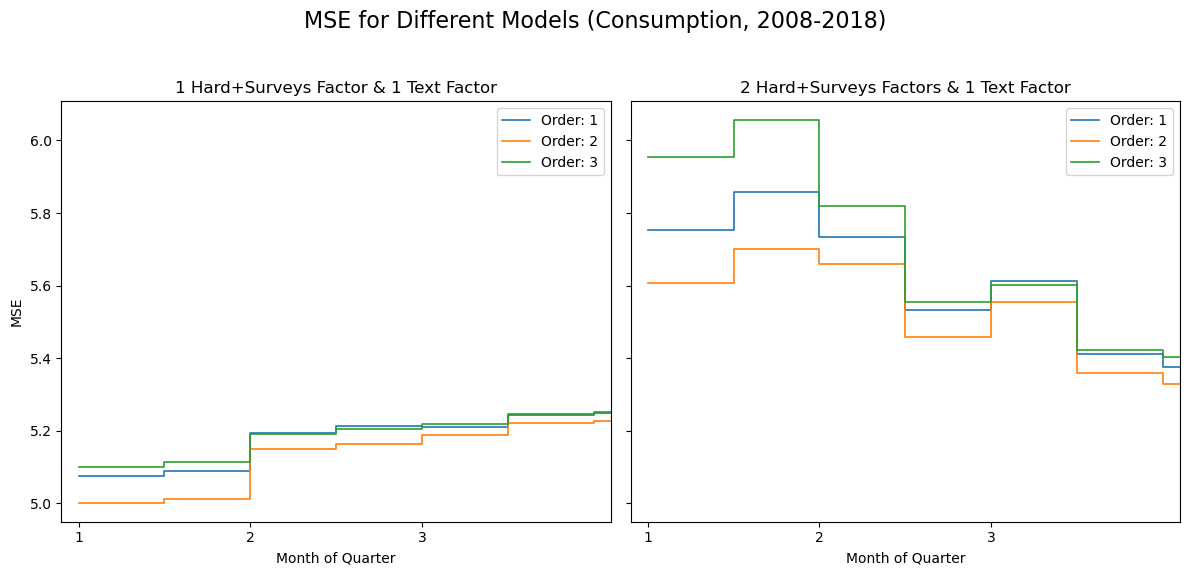

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


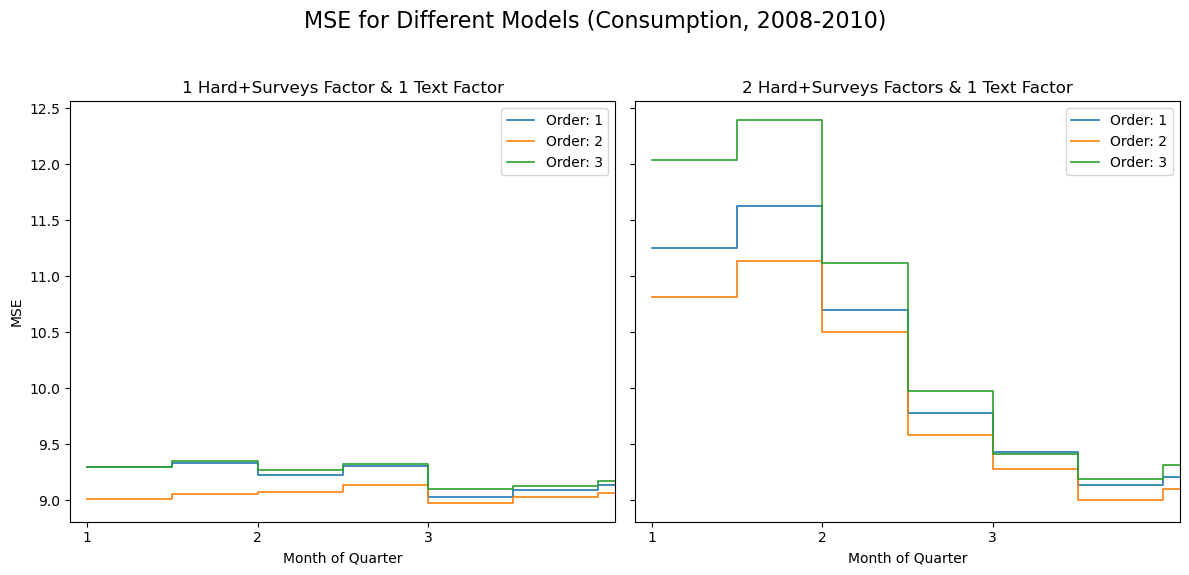

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


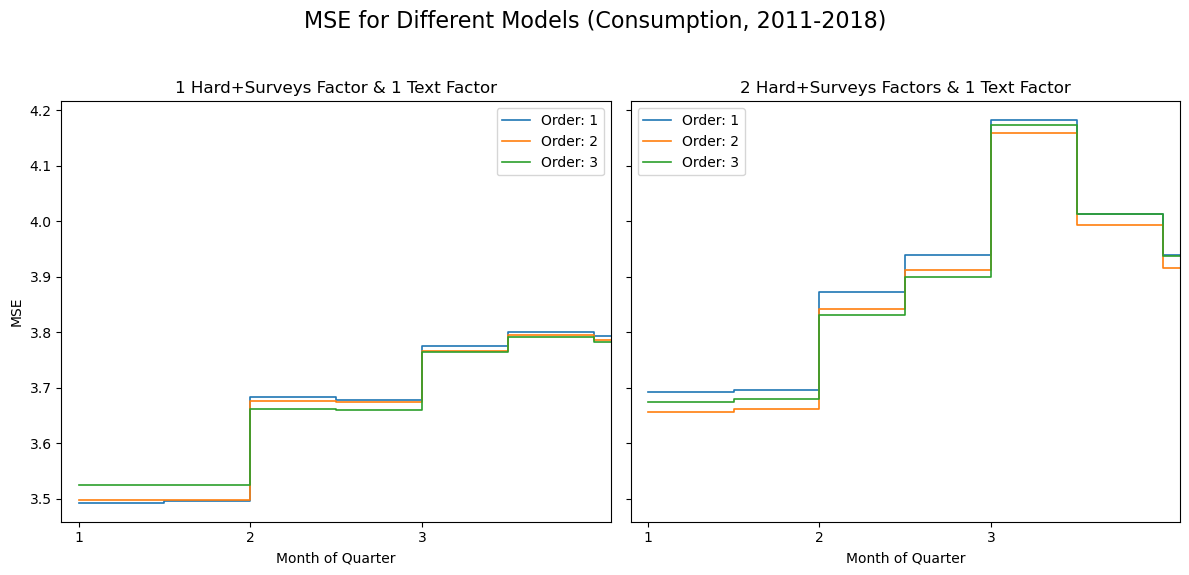

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


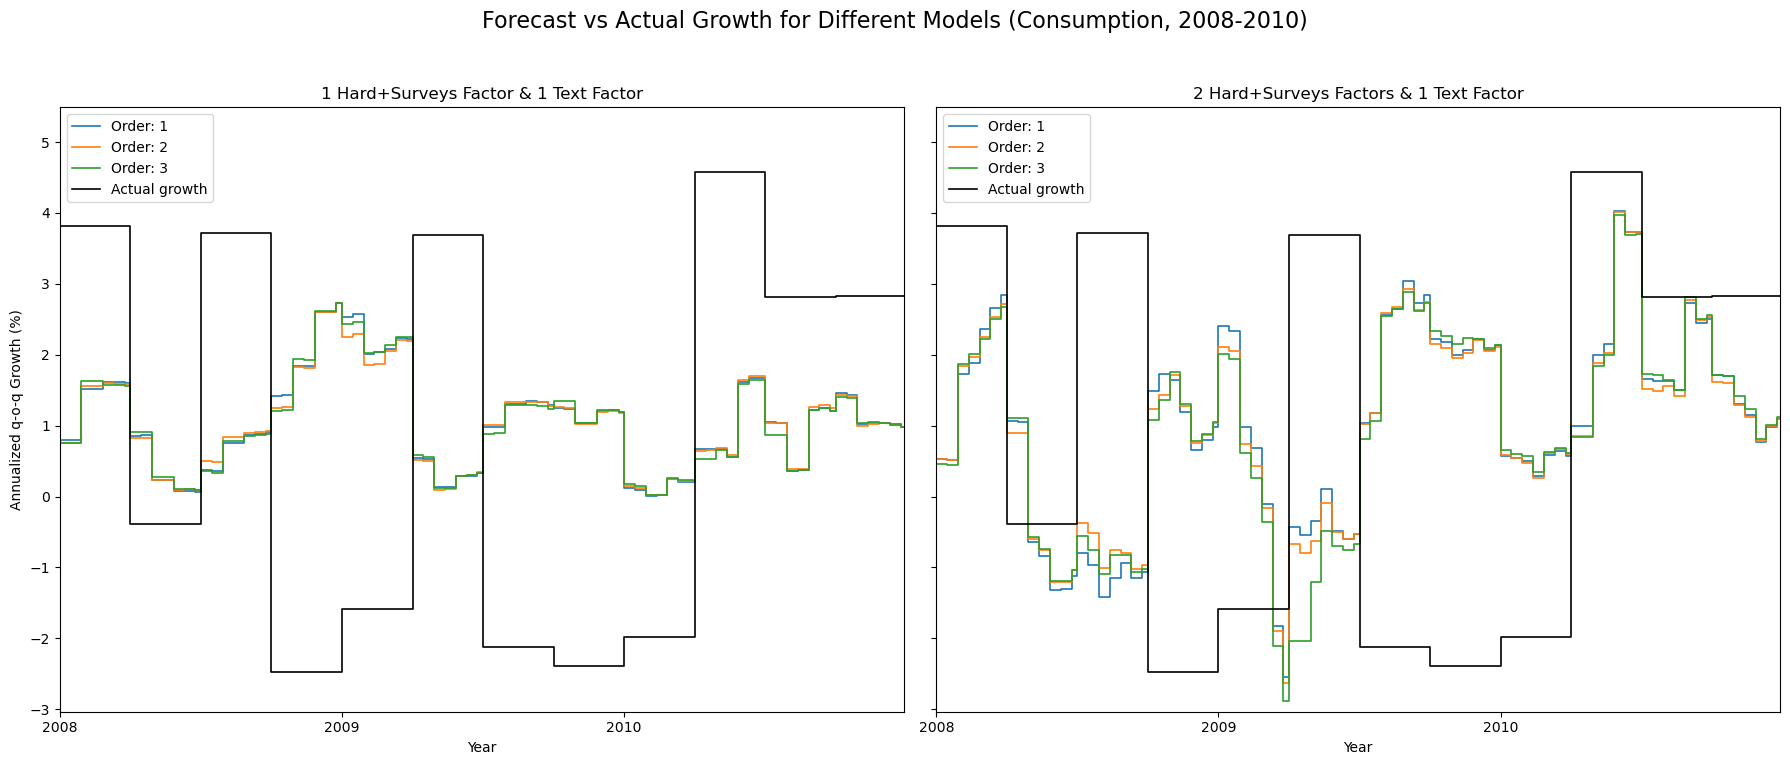

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


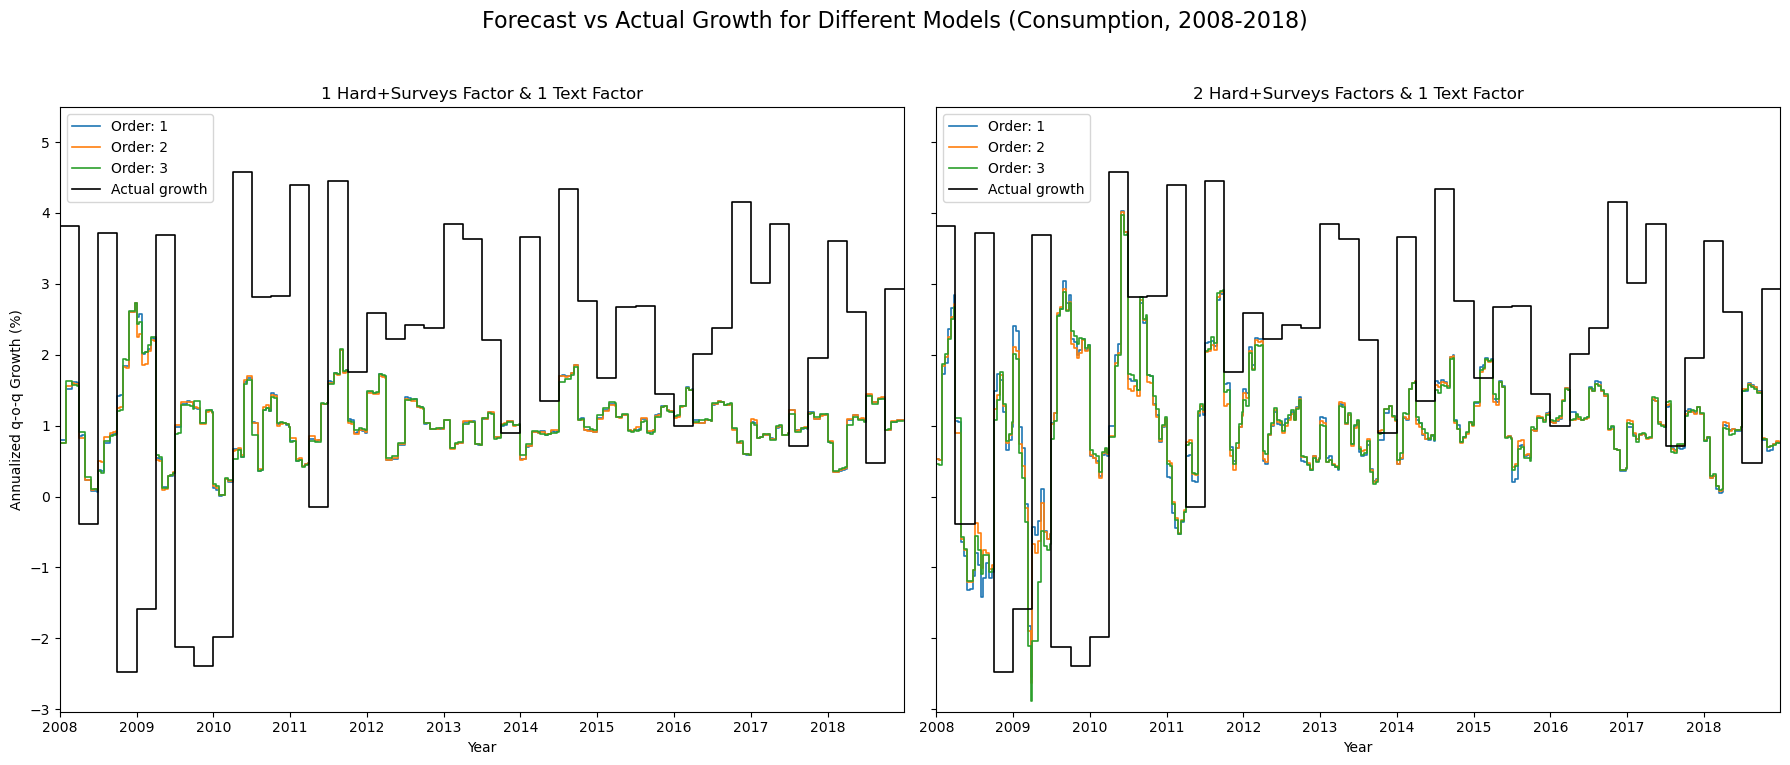

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


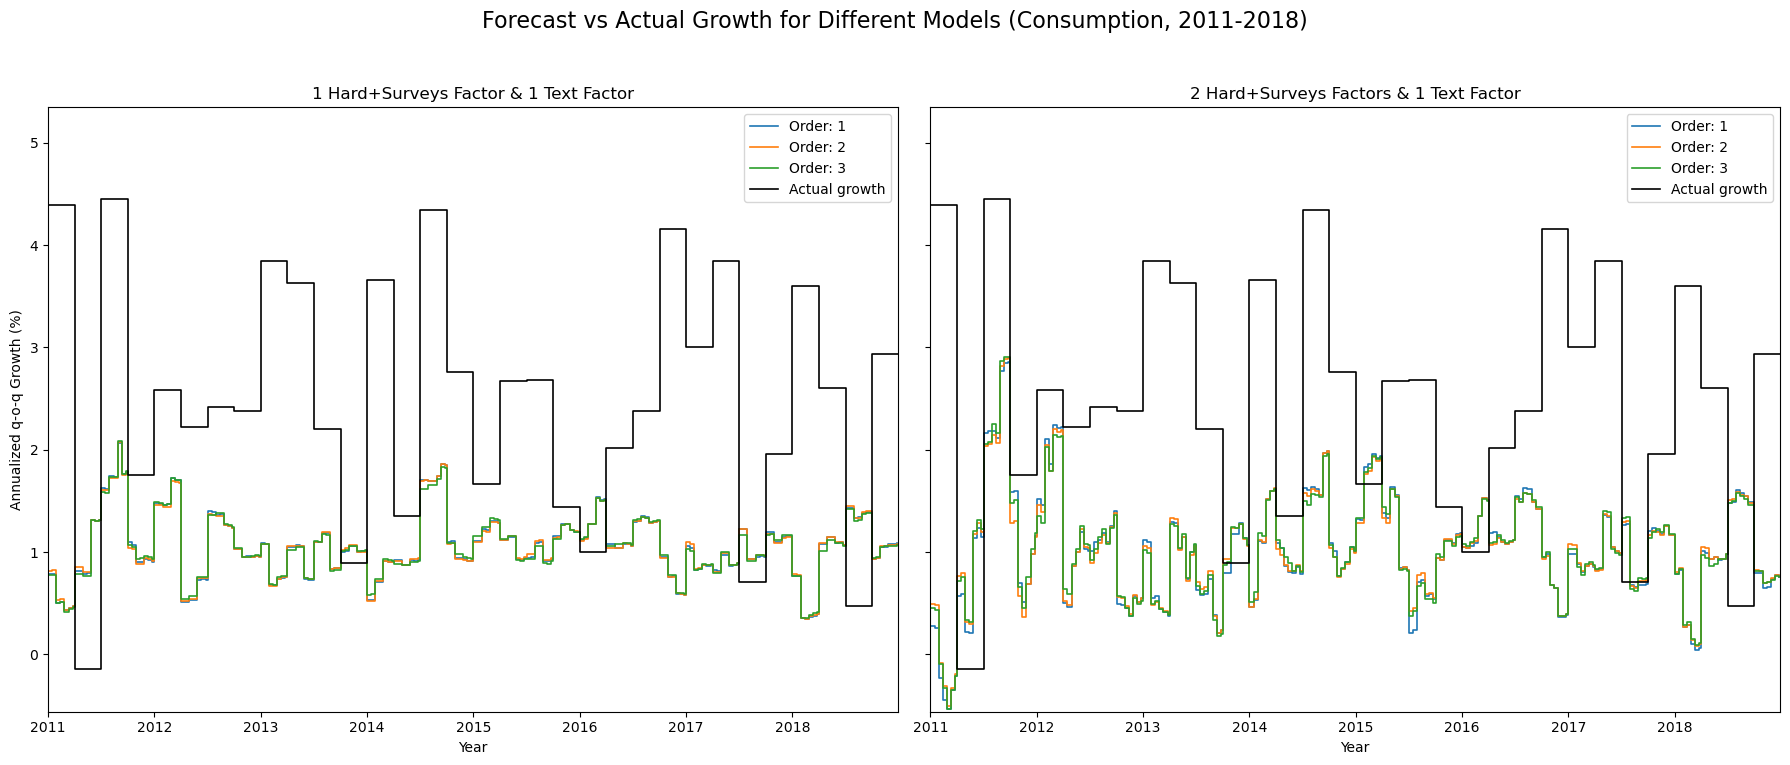

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()